In [1]:
import numpy as np
import mylibrary.nnlib as tnn
import matplotlib.pyplot as plt
import copy

from mpl_toolkits.mplot3d import Axes3D
import matplotlib

import torch
import torch.nn as nn

import mylibrary.datasets as datasets
import prunelib
from tqdm import tqdm
import random

import pickle

In [2]:
mnist = datasets.MNIST()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

In [3]:
train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [4]:
xx = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
yy = torch.LongTensor(train_label_)

In [5]:
net = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
)

In [6]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(150):
    yout = net(xx)

    loss = criterion(yout, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    error = float(loss)
    print(epoch, 'Error = ', error)
    
    with torch.no_grad():
        yout = net(xx)
        out = torch.argmax(yout, axis=1)
        acc = (out.data.numpy() == np.array(train_label_)).astype(np.float).mean()
        print("Accuracy: ", acc)

0 Error =  2.3061201572418213
Accuracy:  0.32206666666666667
1 Error =  2.2662150859832764
Accuracy:  0.4362333333333333
2 Error =  2.1955132484436035
Accuracy:  0.44048333333333334
3 Error =  2.0742175579071045
Accuracy:  0.5366
4 Error =  1.9008814096450806
Accuracy:  0.6062166666666666
5 Error =  1.6918296813964844
Accuracy:  0.6495666666666666
6 Error =  1.466864824295044
Accuracy:  0.6845833333333333
7 Error =  1.2416036128997803
Accuracy:  0.70395
8 Error =  1.0378661155700684
Accuracy:  0.7459333333333333
9 Error =  0.8752355575561523
Accuracy:  0.7595333333333333
10 Error =  0.7762898206710815
Accuracy:  0.7565166666666666
11 Error =  0.722276508808136
Accuracy:  0.7405166666666667
12 Error =  0.7781257033348083
Accuracy:  0.7874666666666666
13 Error =  0.6535302996635437
Accuracy:  0.77245
14 Error =  0.6843119859695435
Accuracy:  0.8076666666666666
15 Error =  0.6135190725326538
Accuracy:  0.8134
16 Error =  0.6054852604866028
Accuracy:  0.8234333333333334
17 Error =  0.56256

In [ ]:
list(net._modules.items())

In [ ]:
torch.save({"model":net.state_dict(), "optimizer":optimizer.state_dict()},
          "./mnist_100_mlp.pth")

In [ ]:
checkpoint = torch.load("./mnist_100_mlp.pth")
net.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])

## Oracle Pruning Modified

## Define pruning function

In [11]:
class Pruner():
    
    def __init__(self, net, prune_mask=None):
        self.net = net
        self.keys = []
        self.prune_mask = {}
        self.forward_hook = {}
        
        self.activations = []
        
        for name, module in list(self.net._modules.items()):
            if isinstance(module, torch.nn.Linear):
                self.keys.append(module)

        if prune_mask is not None:
            self.add_prune_mask(prune_mask)
        self.remove_hook()
        
    def add_prune_mask(self, prune_mask):
        for module, pm in zip(self.keys[:-1], prune_mask):
            self.prune_mask[module] = pm.type(torch.float)
        self.prune_mask[self.keys[-1]] = torch.ones(self.keys[-1].out_features, dtype=torch.float)
            
        
    def prune_neurons(self, module, inp, out):
        mask = self.prune_mask[module]
        output = out*mask
        
        self.activations.append(output)
        return output
        
    def forward(self, x, prune_mask=None):
        if prune_mask:
            self.add_prune_mask(prune_mask)
            if len(self.forward_hook) == 0:
                self.add_hook()
        
        y = self.net(x)
        self.remove_hook()
        return y
        
        
    def add_hook(self):
        if len(self.forward_hook) > 0:
            self.remove_hook()
            
        self.forward_hook = {}
        for name, module in list(self.net._modules.items()):
            if isinstance(module, torch.nn.Linear):
                hook = module.register_forward_hook(self.prune_neurons)
                self.forward_hook[module] = hook
        return
        
    def remove_hook(self):       
        for module in self.forward_hook.keys():
            hook = self.forward_hook[module]
            hook.remove()
        self.forward_hook = {}
        self.prune_mask = {}
        self.activations = []
        return

## comparing for all

In [12]:
methods = []
classes = []

## taylor fo modified
methods = prunelib.taylorfo_mode_list[:3]+prunelib.taylorfo_mode_list[4:6]
classes += [prunelib.Importance_TaylorFO_Modified(net, criterion, config=prunelib.taylorfo_mode_config[method]) for method in methods]

## Molchanov_group, APnZ, Magnitude
# methods += ["Molchanov_group", "APnZ", "Magnitude"]
methods += ["Molchanov_group"]
classes += [
            prunelib.Importance_Molchanov_2019(net, criterion),
            prunelib.Importance_APoZ(net, criterion),
            prunelib.Importance_Magnitude(net, criterion)
            ]

In [13]:
## gather all importances
importances = []
for i in range(len(methods)):
    print(methods[i])
    imp = classes[i].compute_significance(xx, yy)
    importances.append(imp)

taylorfo
taylorfo_abs
taylorfo_sq
taylorfo_abs_norm
taylorfo_sq_norm


  1%|          | 21/1875 [00:00<00:09, 199.03it/s]

Molchanov_group


100%|██████████| 1875/1875 [00:09<00:00, 193.54it/s]


In [14]:
## compute new loss and deviation
loss_lol = []
deviation_lol = []
accuracy_lol = []

pnet = Pruner(net)
yout_normal = net.forward(xx).data.cpu()

for i in range(len(methods)):
    print(methods[i])

    losses = []
    deviations = []
    accuracies = []
    importance = importances[i]
    for num in tqdm(range(1, 401)):
        pmask = prunelib.get_pruning_mask(importance, num_prune=num)
        yout_prune = pnet.forward(xx, prune_mask=pmask).data.cpu()
        new_err = criterion(yout_prune, yy)
        deviation = ((yout_prune-yout_normal)**2).mean()
        out = torch.argmax(yout_prune, axis=1)
        acc = (out.data.numpy() == np.array(train_label_)).astype(np.float).mean()
        
        losses.append(new_err)
        deviations.append(deviation)
        accuracies.append(acc)
        
    loss_lol.append(losses)
    deviation_lol.append(deviations)
    accuracy_lol.append(accuracies)

  0%|          | 0/400 [00:00<?, ?it/s]

taylorfo


  0%|          | 0/400 [00:00<?, ?it/s]

taylorfo_abs


  0%|          | 0/400 [00:00<?, ?it/s]

taylorfo_sq


  0%|          | 0/400 [00:00<?, ?it/s]

taylorfo_abs_norm


  0%|          | 0/400 [00:00<?, ?it/s]

taylorfo_sq_norm


  0%|          | 0/400 [00:00<?, ?it/s]

Molchanov_group


100%|██████████| 400/400 [05:08<00:00,  1.30it/s]


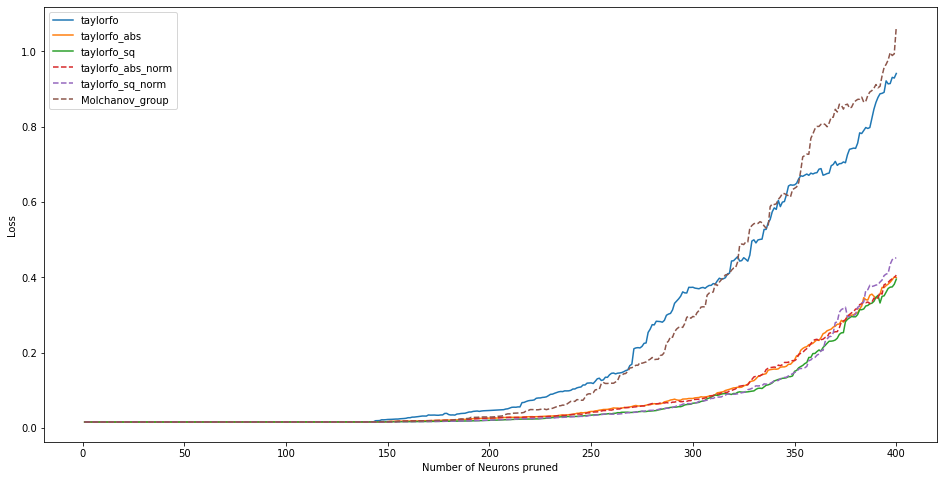

In [15]:
%matplotlib inline
plt.figure(figsize=(16, 8))
xs = list(range(1, 401))
for i in range(len(methods)):
    if i<3:
        ls = "solid"
    elif i<6:
        ls = "dashed"
    elif i<9:
        ls = "dotted"
    elif i<12:
        ls = "dashdot"
    else:
        ls = (0, (3, 5, 1, 5, 1, 5))
    
    plt.plot(xs, loss_lol[i], label=methods[i], linestyle=ls)
plt.legend()
plt.xlabel("Number of Neurons pruned")
plt.ylabel("Loss")
plt.savefig("plt_05_MNIST_pruning_v0_loss_9.svg")

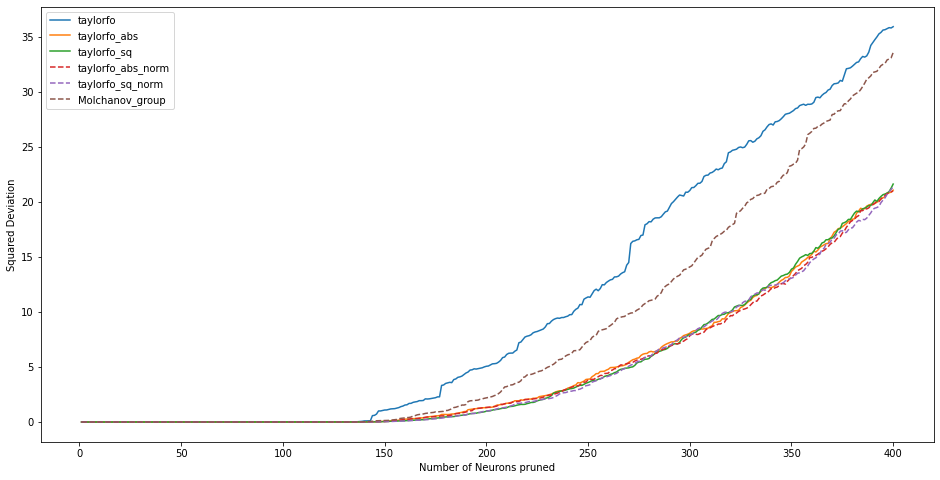

In [16]:
%matplotlib inline
plt.figure(figsize=(16, 8))
xs = list(range(1, 401))
for i in range(len(methods)):
    if i<3:
        ls = "solid"
    elif i<6:
        ls = "dashed"
    elif i<9:
        ls = "dotted"
    elif i<12:
        ls = "dashdot"
    else:
        ls = (0, (3, 5, 1, 5, 1, 5))
    plt.plot(xs, deviation_lol[i], label=methods[i], linestyle=ls)
plt.legend()
plt.xlabel("Number of Neurons pruned")
plt.ylabel("Squared Deviation")
plt.savefig("plt_05_MNIST_pruning_v0_deviation_9.svg")

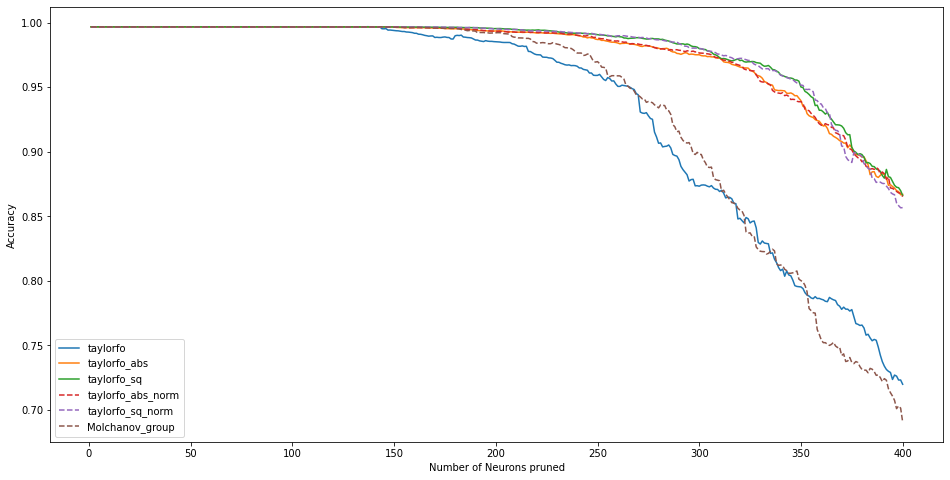

In [17]:
%matplotlib inline
plt.figure(figsize=(16, 8))
xs = list(range(1, 401))
for i in range(len(methods)):
    if i<3:
        ls = "solid"
    elif i<6:
        ls = "dashed"
    elif i<9:
        ls = "dotted"
    elif i<12:
        ls = "dashdot"
    else:
        ls = (0, (3, 5, 1, 5, 1, 5))
    plt.plot(xs, accuracy_lol[i], label=methods[i], linestyle=ls)
plt.legend()
plt.xlabel("Number of Neurons pruned")
plt.ylabel("Accuracy")
plt.savefig("plt_05_MNIST_pruning_v0_accuracy_9.svg")

In [18]:
exit(0)

In [19]:
this is to break the running of code right about here

SyntaxError: invalid syntax (<ipython-input-19-ba871b538225>, line 1)

In [ ]:
# data = {"loss":loss_lol, "deviation":deviation_lol, "accuracy":accuracy_lol}
# with open('data_05_MNIST_pruning_v0_2.pkl', 'wb') as f:
#     pickle.dump(data, f)

In [ ]:
# with open('data_05_MNIST_pruning_v0_2.pkl', 'rb') as f:
#     data = pickle.load(f)
# loss_lol = data["loss"]
# deviation_lol = data["deviation"]
# accuracy_lol = data["accuracy"]

## Compare

In [ ]:
"""
settings:
1,2,3 -> net = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
)

4,5 -> net = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)

6, 7 -> net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)
8, 9 -> net = nn.Sequential(
    nn.Linear(784, 400),
    nn.ReLU(),
    nn.Linear(400, 300),
    nn.ReLU(),
    nn.Linear(300, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)
"""

### taylorfo vs taylorfo_norm

In [ ]:
%matplotlib inline
plt.figure(figsize=(16, 8))
xs = list(range(1, 401))
for i in [0,1,2,3,4,5]:
    if i<3:
        ls = "solid"
    elif i<6:
        ls = "dashed"
    elif i<9:
        ls = "dotted"
    elif i<12:
        ls = "dashdot"
    else:
        ls = (0, (3, 5, 1, 5, 1, 5))
    
    plt.plot(xs, loss_lol[i], label=methods[i], linestyle=ls)
plt.legend()
plt.xlabel("Number of Neurons pruned")
plt.ylabel("Loss")
# plt.savefig("plt_05_MNIST_pruning_v0_loss_taylor_2.svg")

In [ ]:
%matplotlib inline
plt.figure(figsize=(16, 8))
xs = list(range(1, 401))
for i in [0,1,2,3,4,5]:
    if i<3:
        ls = "solid"
    elif i<6:
        ls = "dashed"
    elif i<9:
        ls = "dotted"
    elif i<12:
        ls = "dashdot"
    else:
        ls = (0, (3, 5, 1, 5, 1, 5))
    plt.plot(xs, deviation_lol[i], label=methods[i], linestyle=ls)
plt.legend()
plt.xlabel("Number of Neurons pruned")
plt.ylabel("Squared Deviation")
# plt.savefig("plt_05_MNIST_pruning_v0_deviation_taylor_2.svg")

In [ ]:
%matplotlib inline
plt.figure(figsize=(16, 8))
xs = list(range(1, 401))
for i in [0,1,2,3,4,5]:
    if i<3:
        ls = "solid"
    elif i<6:
        ls = "dashed"
    elif i<9:
        ls = "dotted"
    elif i<12:
        ls = "dashdot"
    else:
        ls = (0, (3, 5, 1, 5, 1, 5))
    plt.plot(xs, accuracy_lol[i], label=methods[i], linestyle=ls)
plt.legend()
plt.xlabel("Number of Neurons pruned")
plt.ylabel("Accuracy")
# plt.savefig("plt_05_MNIST_pruning_v0_accuracy_taylor_2.svg")

### taylorfo vs taylorfo_norm

In [ ]:
%matplotlib inline
plt.figure(figsize=(16, 8))
xs = list(range(1, 401))
for i in [1,2,4,5,7,8,10,11]:
    if i<3:
        ls = "solid"
    elif i<6:
        ls = "dashed"
    elif i<9:
        ls = "dotted"
    elif i<12:
        ls = "dashdot"
    else:
        ls = (0, (3, 5, 1, 5, 1, 5))
    
    plt.plot(xs, loss_lol[i], label=methods[i], linestyle=ls)
plt.legend()
plt.xlabel("Number of Neurons pruned")
plt.ylabel("Loss")
# plt.savefig("plt_05_MNIST_pruning_v0_loss_nolinear_2.svg")

In [ ]:
%matplotlib inline
plt.figure(figsize=(16, 8))
xs = list(range(1, 401))
for i in [1,2,4,5,7,8,10,11]:
    if i<3:
        ls = "solid"
    elif i<6:
        ls = "dashed"
    elif i<9:
        ls = "dotted"
    elif i<12:
        ls = "dashdot"
    else:
        ls = (0, (3, 5, 1, 5, 1, 5))
    plt.plot(xs, deviation_lol[i], label=methods[i], linestyle=ls)
plt.legend()
plt.xlabel("Number of Neurons pruned")
plt.ylabel("Squared Deviation")
# plt.savefig("plt_05_MNIST_pruning_v0_deviation_nolinear_2.svg")

In [ ]:
%matplotlib inline
plt.figure(figsize=(16, 8))
xs = list(range(1, 401))
for i in [1,2,4,5,7,8,10,11]:
    if i<3:
        ls = "solid"
    elif i<6:
        ls = "dashed"
    elif i<9:
        ls = "dotted"
    elif i<12:
        ls = "dashdot"
    else:
        ls = (0, (3, 5, 1, 5, 1, 5))
    plt.plot(xs, accuracy_lol[i], label=methods[i], linestyle=ls)
plt.legend()
plt.xlabel("Number of Neurons pruned")
plt.ylabel("Accuracy")
# plt.savefig("plt_05_MNIST_pruning_v0_accuracy_nolinear_2.svg")